# Movielens 영화 SBR

## 라이브러리 임포트

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드
### 1-1. 데이터셋 파악
* 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
* 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

In [4]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 1-2. Session ID 생성 및 컬럼정리
* ~~UserId - Date(당일 활동기준)를 기준으로 고유 세션처리 했을 때,~~ 세션 갯수가 2만여개로 축소된다.(취소)
* UserId - Time(제출 기준) 을 기준으로 고유 세션처리 하자.
* Time 컬럼을 DateTime 값으로 변형하자(눈으로 확인하는 데에도, 날짜 계산에도 용이)

In [5]:
session_df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
session_df.reset_index(inplace=True)
session_df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [6]:
# 기존 DataFrame과 세션테이블 결합
data = pd.merge(data, session_df, on=['UserId', 'Time'])
data.head()

,UserId,ItemId_x,Rating,Time,index,ItemId_y
0,1,3186,4,978300019,0,1
1,1,1270,5,978300055,1,3
2,1,1721,4,978300055,1,3
3,1,1022,5,978300055,1,3
4,1,2340,3,978300103,2,1


In [7]:
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data.head()

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2


* Timestamp to DateTime
    * 978300019 -> 2000-12-31 22:00:19

In [8]:
data['dt'] = data['Time'].apply(lambda x: dt.datetime.fromtimestamp(x))
del data['Time']
data.rename(columns=dict(dt='Time'), inplace=True)
data.head()

,UserId,ItemId,Rating,SessionId,Time
0,1,3186,4,0,2000-12-31 22:00:19
1,1,1270,5,1,2000-12-31 22:00:55
2,1,1721,4,1,2000-12-31 22:00:55
3,1,1022,5,1,2000-12-31 22:00:55
4,1,2340,3,2,2000-12-31 22:01:43


In [9]:
oldest, latest = data['Time'].min(), data['Time'].max()
print("oldest:", oldest)
print("latest:", latest)
type(latest)
print("total range:", latest - oldest)

oldest: 2000-04-25 23:05:32
latest: 2003-02-28 17:49:50
total range: 1038 days 18:44:18


In [10]:
# 주요 컬럼 Unique 갯수 파악
print(f"UserId: {data['UserId'].nunique():,}개, ItemId:{data['ItemId'].nunique():,}개, SessionId: {data['SessionId'].nunique():,}개")

UserId: 6,040개, ItemId:3,706개, SessionId: 471,163개


### 1-3. Session Length
* 세션별 데이터 파악
* ~~무의미한 데이터 1차 제거(평점 3점 미만)~~(3점 미만 데이터를 제거하니 정확도가 너무 떨어진다)

In [11]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [12]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [13]:
session_length.min(), session_length.max()

(1, 30)

In [14]:
session_length.quantile(0.999)

10.0

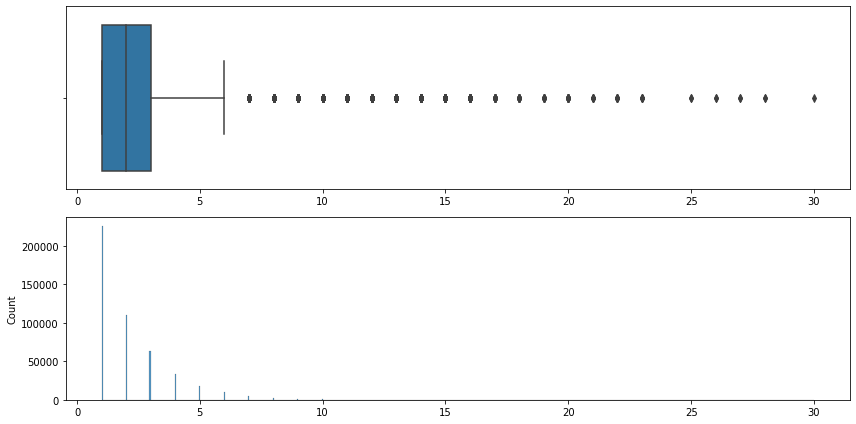

In [15]:
# 박스플롯과 히스토그램으로 분포도를 확인해본다
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.boxplot(session_length)

plt.subplot(212)
sns.histplot(session_length)

plt.tight_layout()

> 약 7회 이상부턴 이상치로 판단된다. 다만 이것들이 어떤 의미인지 확실하지 않은 상태에서, 함부로 날릴 수가 없다.

In [16]:
# 30회 클릭한 세션 까보기
long_session = session_length[session_length==30].index[0]
chk_long = data[data['SessionId']==long_session]
chk_long

,UserId,ItemId,Rating,SessionId,Time
112347,731,3044,4,55117,2000-11-29 20:06:42
112348,731,1455,3,55117,2000-11-29 20:06:42
112349,731,1639,5,55117,2000-11-29 20:06:42
112350,731,3244,4,55117,2000-11-29 20:06:42
112351,731,1656,2,55117,2000-11-29 20:06:42
112352,731,3426,4,55117,2000-11-29 20:06:42
112353,731,1829,2,55117,2000-11-29 20:06:42
112354,731,2675,4,55117,2000-11-29 20:06:42
112355,731,802,3,55117,2000-11-29 20:06:42
112356,731,803,5,55117,2000-11-29 20:06:42


In [17]:
min_dt, max_dt = chk_long['Time'].min(), chk_long['Time'].max()
print(min_dt)
print(max_dt)
print(f"유저 {chk_long['UserId'].iloc[0]}는 {max_dt - min_dt} 동안 {chk_long['ItemId'].nunique():,}개 아이템을 봤음")

2000-11-29 20:06:42
2000-11-29 20:06:42
유저 731는 0 days 00:00:00 동안 30개 아이템을 봤음


> 물리적으로 1초도 안되는 시간에 30개의 점수를 매기거나, 클릭할 수 없다.
>
> 아마 하나씩 점수를 메기지 않고, 리스트에서 여러개의 점수를 일괄적으로 메긴 후 `제출하기` 같은 장치로 데이터를 전송받은 기록 같다.

In [18]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

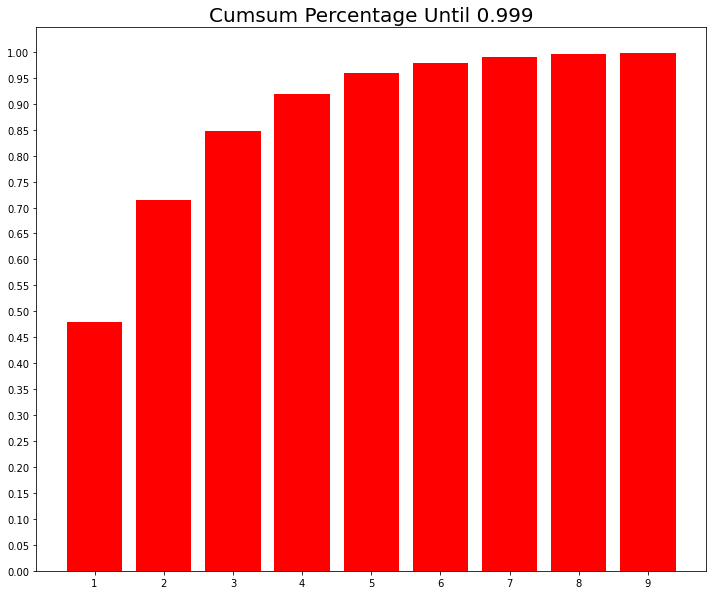

In [19]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### - 기간으로 자르기 적당한지 확인

In [20]:
for year in range(1, 4):
    month_ago = latest - dt.timedelta(days=365 * year) # 마지막 날짜로부터 n년 전 날짜를 구한다.
    print(f"year: {year}+, len: {len(data[data['Time'] > month_ago]):,}개 데이터") # 방금 구한 날짜 이후의 데이터만 모은다.

year: 1+, len: 21,704개 데이터
year: 2+, len: 69,349개 데이터
year: 3+, len: 1,000,209개 데이터


* 3년까지 범위를 넓혀야만 데이터가 충분하다.
* 과거의 평점 데이터도 현재 추천하는 데 충분히 활용될 수 있으므로, 전 기간 사용해도 될 것 같다.

#### - 점수로 자르기 적당한지 확인

Rating Mean: 3.581564453029317 , Rating Median: 4.0


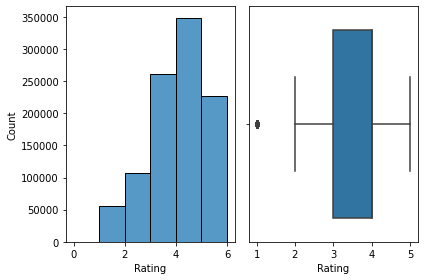

In [21]:
plt.subplot(121)
sns.histplot(data['Rating'], bins=np.arange(0, 7))
plt.subplot(122)
sns.boxplot(data['Rating'])
plt.tight_layout()
print('Rating Mean:', data['Rating'].mean(), ', Rating Median:', data['Rating'].median())

In [22]:
for year in range(1, 4):
    month_ago = latest - dt.timedelta(days=365 * year) # 마지막 날짜로부터 n년 전 날짜를 구한다.
    print(f"year: {year}+, len: {len(data[(data['Time'] > month_ago) & (data['Rating'] >= 3)]):,}개 데이터") # 방금 구한 날짜 이후의 데이터만 모은다.

year: 1+, len: 17,567개 데이터
year: 2+, len: 56,922개 데이터
year: 3+, len: 836,478개 데이터


Rating Mean: 3.958292985589579 , Rating Median: 4.0


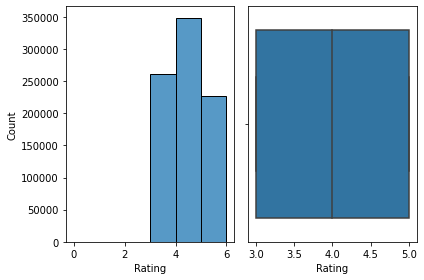

In [23]:
plt.subplot(121)
sns.histplot(data[data['Rating'] >= 3]['Rating'], bins=np.arange(0, 7))
plt.subplot(122)
sns.boxplot(data[data['Rating'] >= 3]['Rating'])
plt.tight_layout()
print('Rating Mean:', data[data['Rating'] >= 3]['Rating'].mean(), ', Rating Median:', data[data['Rating'] >= 3]['Rating'].median())

In [24]:
# data = data[data['Rating'] >= 3]
# data

> Rating 3 미만 데이터는 제거해도 무방할 것 같았는데, 그렇게 진행하면 정확도가 많이 떨어진다.

### 1-4. Data Cleansing

In [25]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [26]:
# Cleansing 전 데이터 파악
print(f"ItemId:{data['ItemId'].nunique():,}개, SessionId: {data['SessionId'].nunique():,}개")

ItemId:3,706개, SessionId: 471,163개


In [27]:
data = cleanse_recursive(data, shortest=2, least_click=5)
# Cleansing 후 데이터 파악
print(f"ItemId: {data['ItemId'].nunique():,}개, SessionId: {data['SessionId'].nunique():,}개")
data.reset_index(inplace=True, drop=True)
data

ItemId: 3,333개, SessionId: 244,816개


,UserId,ItemId,Rating,SessionId,Time
0,1,1270,5,1,2000-12-31 22:00:55
1,1,1721,4,1,2000-12-31 22:00:55
2,1,1022,5,1,2000-12-31 22:00:55
3,1,2804,5,5,2000-12-31 22:11:59
4,1,1207,4,5,2000-12-31 22:11:59
...,...,...,...,...,...
773230,6040,3362,4,471145,2001-08-10 14:29:56
773231,6040,3421,3,471146,2001-08-10 14:31:49
773232,6040,1258,4,471146,2001-08-10 14:31:49
773233,6040,1921,4,471160,2001-08-10 14:41:04


Cleanse 이후
* ItemId: 3,706개 => 3,333개
* SessionId: 471,163개 => 244,816개 로 감소

In [28]:
# 쓰지 않을 컬럼 삭제하고 순서 변경
data = data[['SessionId', 'ItemId', 'Time']]
data.head()

,SessionId,ItemId,Time
0,1,1270,2000-12-31 22:00:55
1,1,1721,2000-12-31 22:00:55
2,1,1022,2000-12-31 22:00:55
3,5,2804,2000-12-31 22:11:59
4,5,1207,2000-12-31 22:11:59


### 1-5. Train / Valid / Test split
* Train / Test / Valid 데이터를 60일 간격으로 쪼개자

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(days=n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(days=n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [30]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status.title()} Set Stats Info\n'
          f'\t Events: {len(data):,}\n'
          f'\t Sessions: {data["SessionId"].nunique():,}\n'
          f'\t Items: {data["ItemId"].nunique():,}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
tr, test = split_by_date(data, n_days=60)  # [전기간 | 최근60일]
tr, val = split_by_date(tr, n_days=60)  # [전기간(테스트 데이터 제거 후) | 최근60일]

stats_info(data, 'origin_data')
stats_info(tr, 'train_set')
stats_info(val, 'validation_set')
stats_info(test, 'test_set')

* Origin_Data Set Stats Info
	 Events: 773,235
	 Sessions: 244,816
	 Items: 3,333
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2003-02-28 17:49:08

* Train_Set Set Stats Info
	 Events: 770,095
	 Sessions: 243,624
	 Items: 3,333
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-10-31 16:33:08

* Validation_Set Set Stats Info
	 Events: 1,459
	 Sessions: 570
	 Items: 956
	 First Time : 2002-11-01 02:56:19
	 Last Time : 2002-12-30 16:43:35

* Test_Set Set Stats Info
	 Events: 1,681
	 Sessions: 622
	 Items: 1,061
	 First Time : 2002-12-30 19:40:25
	 Last Time : 2003-02-28 17:49:08



### 1-6. Item Indexing

In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

print("validation_set item_idx==-1 인 갯수:", len(val[val['item_idx'] == -1]))
print("test_set의 item_idx==-1 인 갯수:", len(test[test['item_idx'] == -1]))

validation_set item_idx==-1 인 갯수: 0
test_set의 item_idx==-1 인 갯수: 0


In [33]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. Data Pipeline
### 2-1. SessionDataset

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [35]:
# SessionDataset 객체 만들기

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,ItemId,Time,item_idx
0,1,1270,2000-12-31 22:00:55,0
1,1,1721,2000-12-31 22:00:55,1
2,1,1022,2000-12-31 22:00:55,2
3,5,2804,2000-12-31 22:11:59,3
4,5,1207,2000-12-31 22:11:59,4
5,6,1193,2000-12-31 22:12:40,5
6,6,720,2000-12-31 22:12:40,6
7,6,260,2000-12-31 22:12:40,7
8,14,1035,2000-12-31 22:29:13,8
9,14,1962,2000-12-31 22:29:13,9


In [36]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 770091, 770093, 770095], dtype=int32)

In [37]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 243621, 243622, 243623])

### 2-2. SessionDataLoader

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=100)
tr_dataset.df.head(5)

,SessionId,ItemId,Time,item_idx
0,1,1270,2000-12-31 22:00:55,0
1,1,1721,2000-12-31 22:00:55,1
2,1,1022,2000-12-31 22:00:55,2
3,5,2804,2000-12-31 22:11:59,3
4,5,1207,2000-12-31 22:11:59,4


## 3. Modeling
### 3-1. Evaluation Metric

In [40]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3-2. Model Architecture

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [42]:
# 하이퍼파라미터를 클래스로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args, adjust):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    results = dict(
        **{key:[] for key in adjust.keys()},
        epoch = [],
        recall = [],
        mrr = [],
    )

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}/{args.epochs}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}/{args.epochs}: {val_mrr:3f}\n")

        for k, v in adjust.items():
            results[k] = v

        results['epoch'].append(epoch)
        results['recall'].append(val_recall)
        results['mrr'].append(val_mrr)

    return results

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print()
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 3-3. Model Training
* 하이퍼파라미터 변경 실험
    * batch_size, learning_reate, epochs

In [44]:
result_df = pd.DataFrame()
for b_size in [512, 256, 128]:
    args = Args(tr, val, test, batch_size=b_size, hsz=50, drop_rate=0.3, lr=0.001, epochs=3, k=20)
    model = create_model(args)

    results = train_model(model, args, adjust=dict(batch_size=b_size))
    result_df = pd.concat([result_df, pd.DataFrame(results)], ignore_index=True)

result_df

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    507750    
_________________________________________________________________
dropout (Dropout)            (512, 50)                 0         
_________________________________________________________________
dense (Dense)                (512, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


	 - Recall@20 epoch 1/3: 0.025391
	 - MRR@20    epoch 1/3: 0.005076



Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


	 - Recall@20 epoch 2/3: 0.037109
	 - MRR@20    epoch 2/3: 0.007564



Evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


	 - Recall@20 epoch 3/3: 0.056641
	 - MRR@20    epoch 3/3: 0.011804

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    507750    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]


	 - Recall@20 epoch 1/3: 0.027344
	 - MRR@20    epoch 1/3: 0.004264



Evaluation:  67%|██████▋   | 2/3 [00:02<00:01,  1.07s/it]


	 - Recall@20 epoch 2/3: 0.074219
	 - MRR@20    epoch 2/3: 0.015082



Evaluation:  67%|██████▋   | 2/3 [00:02<00:01,  1.15s/it]


	 - Recall@20 epoch 3/3: 0.105469
	 - MRR@20    epoch 3/3: 0.030629

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


	 - Recall@20 epoch 1/3: 0.085938
	 - MRR@20    epoch 1/3: 0.022928



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 2/3: 0.165365
	 - MRR@20    epoch 2/3: 0.044778



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

	 - Recall@20 epoch 3/3: 0.194010
	 - MRR@20    epoch 3/3: 0.059402



,batch_size,epoch,recall,mrr
0,512,1,0.025391,0.005076
1,512,2,0.037109,0.007564
2,512,3,0.056641,0.011804
3,256,1,0.027344,0.004264
4,256,2,0.074219,0.015082
5,256,3,0.105469,0.030629
6,128,1,0.085938,0.022928
7,128,2,0.165365,0.044778
8,128,3,0.194010,0.059402


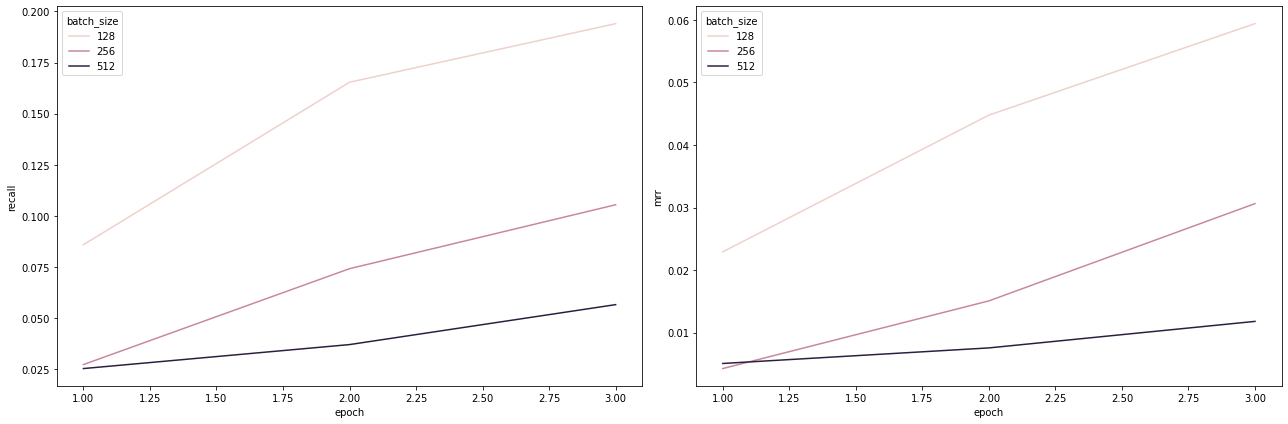

In [45]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.lineplot(x='epoch', y='recall', hue='batch_size', data=result_df)

plt.subplot(122)
sns.lineplot(x='epoch', y='mrr', hue='batch_size', data=result_df)

plt.tight_layout()

> batch_size는 `[128, 256, 512]`중에서 `128`이 가장 적합하다.

In [51]:
lr_result_df = pd.DataFrame()
for l_r in [0.01, 0.005, 0.001]:
    args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.3, lr=l_r, epochs=3, k=20)
    model = create_model(args)

    results = train_model(model, args, adjust=dict(learning_rate=l_r))
    lr_result_df = pd.concat([lr_result_df, pd.DataFrame(results)], ignore_index=True)

lr_result_df

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_9 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_9 (Dense)              (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


	 - Recall@20 epoch 1/3: 0.177083
	 - MRR@20    epoch 1/3: 0.059357



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


	 - Recall@20 epoch 2/3: 0.167969
	 - MRR@20    epoch 2/3: 0.054061



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


	 - Recall@20 epoch 3/3: 0.165365
	 - MRR@20    epoch 3/3: 0.057436

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_10 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_10 (Dense)             (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


	 - Recall@20 epoch 1/3: 0.167969
	 - MRR@20    epoch 1/3: 0.049570



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


	 - Recall@20 epoch 2/3: 0.191406
	 - MRR@20    epoch 2/3: 0.056863



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


	 - Recall@20 epoch 3/3: 0.192708
	 - MRR@20    epoch 3/3: 0.058988

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_11 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_11 (Dense)             (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


	 - Recall@20 epoch 1/3: 0.088542
	 - MRR@20    epoch 1/3: 0.023565



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


	 - Recall@20 epoch 2/3: 0.162760
	 - MRR@20    epoch 2/3: 0.046124



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

	 - Recall@20 epoch 3/3: 0.190104
	 - MRR@20    epoch 3/3: 0.057463



,learning_rate,epoch,recall,mrr
0,0.010,1,0.177083,0.059357
1,0.010,2,0.167969,0.054061
2,0.010,3,0.165365,0.057436
3,0.005,1,0.167969,0.049570
4,0.005,2,0.191406,0.056863
5,0.005,3,0.192708,0.058988
6,0.001,1,0.088542,0.023565
7,0.001,2,0.162760,0.046124
8,0.001,3,0.190104,0.057463


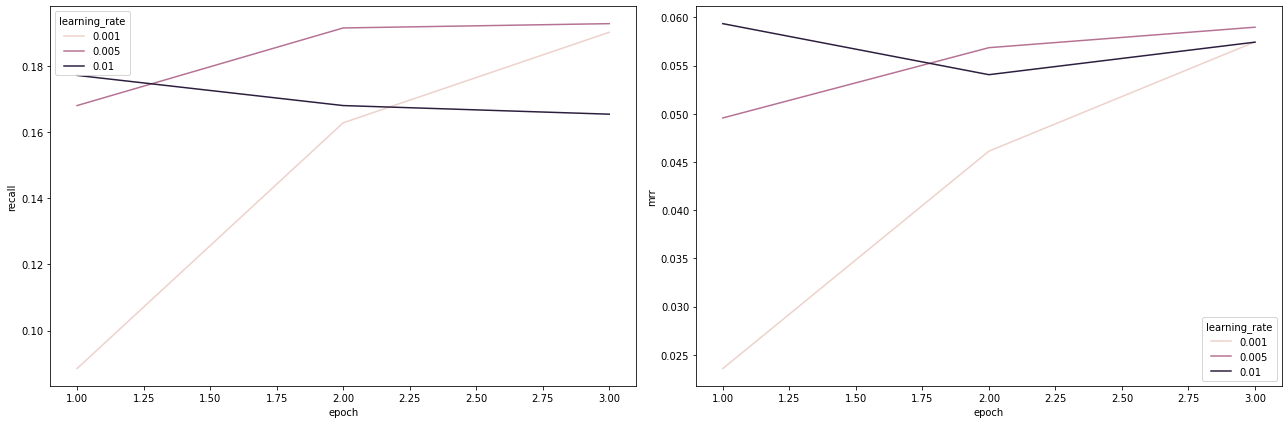

In [52]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.lineplot(x='epoch', y='recall', hue='learning_rate', data=lr_result_df)

plt.subplot(122)
sns.lineplot(x='epoch', y='mrr', hue='learning_rate', data=lr_result_df)

plt.tight_layout()

> learning_rate는 `[0.01, 0.005, 0.001]`중에서 `0.001`이 가장 적합하다.

In [53]:
epoch_result_df = pd.DataFrame()
for epochs in [7, 10, 13]:
    args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.3, lr=0.001, epochs=epochs, k=20)
    model = create_model(args)

    results = train_model(model, args, adjust=dict(epochs=epochs))
    epoch_result_df = pd.concat([epoch_result_df, pd.DataFrame(results)], ignore_index=True)

epoch_result_df

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_12 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_12 (Dense)             (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


	 - Recall@20 epoch 1/7: 0.085938
	 - MRR@20    epoch 1/7: 0.022237



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


	 - Recall@20 epoch 2/7: 0.160156
	 - MRR@20    epoch 2/7: 0.050098



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]


	 - Recall@20 epoch 3/7: 0.191406
	 - MRR@20    epoch 3/7: 0.059097



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


	 - Recall@20 epoch 4/7: 0.192708
	 - MRR@20    epoch 4/7: 0.061173



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


	 - Recall@20 epoch 5/7: 0.208333
	 - MRR@20    epoch 5/7: 0.064797



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


	 - Recall@20 epoch 6/7: 0.208333
	 - MRR@20    epoch 6/7: 0.067615



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 7/7: 0.223958
	 - MRR@20    epoch 7/7: 0.071802

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_13 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_13 (Dense)             (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


	 - Recall@20 epoch 1/10: 0.088542
	 - MRR@20    epoch 1/10: 0.022138



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


	 - Recall@20 epoch 2/10: 0.154948
	 - MRR@20    epoch 2/10: 0.042022



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 3/10: 0.190104
	 - MRR@20    epoch 3/10: 0.055515



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


	 - Recall@20 epoch 4/10: 0.201823
	 - MRR@20    epoch 4/10: 0.060212



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


	 - Recall@20 epoch 5/10: 0.217448
	 - MRR@20    epoch 5/10: 0.062852



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


	 - Recall@20 epoch 6/10: 0.214844
	 - MRR@20    epoch 6/10: 0.061075



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 7/10: 0.225260
	 - MRR@20    epoch 7/10: 0.062266



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


	 - Recall@20 epoch 8/10: 0.223958
	 - MRR@20    epoch 8/10: 0.065425



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]


	 - Recall@20 epoch 9/10: 0.225260
	 - MRR@20    epoch 9/10: 0.064290



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 10/10: 0.223958
	 - MRR@20    epoch 10/10: 0.066819

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(128, 1, 3333)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    507750    
_________________________________________________________________
dropout_14 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_14 (Dense)             (128, 3333)               169983    
Total params: 677,733
Trainable params: 677,733
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


	 - Recall@20 epoch 1/13: 0.083333
	 - MRR@20    epoch 1/13: 0.022897



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


	 - Recall@20 epoch 2/13: 0.156250
	 - MRR@20    epoch 2/13: 0.045772



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 3/13: 0.192708
	 - MRR@20    epoch 3/13: 0.058035



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 4/13: 0.209635
	 - MRR@20    epoch 4/13: 0.062071



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.95it/s]


	 - Recall@20 epoch 5/13: 0.210938
	 - MRR@20    epoch 5/13: 0.065220



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


	 - Recall@20 epoch 6/13: 0.214844
	 - MRR@20    epoch 6/13: 0.069470



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


	 - Recall@20 epoch 7/13: 0.218750
	 - MRR@20    epoch 7/13: 0.070392



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


	 - Recall@20 epoch 8/13: 0.218750
	 - MRR@20    epoch 8/13: 0.070448



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


	 - Recall@20 epoch 9/13: 0.218750
	 - MRR@20    epoch 9/13: 0.071897



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 10/13: 0.218750
	 - MRR@20    epoch 10/13: 0.073285



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]


	 - Recall@20 epoch 11/13: 0.222656
	 - MRR@20    epoch 11/13: 0.073649



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


	 - Recall@20 epoch 12/13: 0.221354
	 - MRR@20    epoch 12/13: 0.070015



Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

	 - Recall@20 epoch 13/13: 0.220052
	 - MRR@20    epoch 13/13: 0.071164



,epochs,epoch,recall,mrr
0,7,1,0.085938,0.022237
1,7,2,0.160156,0.050098
2,7,3,0.191406,0.059097
3,7,4,0.192708,0.061173
4,7,5,0.208333,0.064797
5,7,6,0.208333,0.067615
6,7,7,0.223958,0.071802
7,10,1,0.088542,0.022138
8,10,2,0.154948,0.042022
9,10,3,0.190104,0.055515


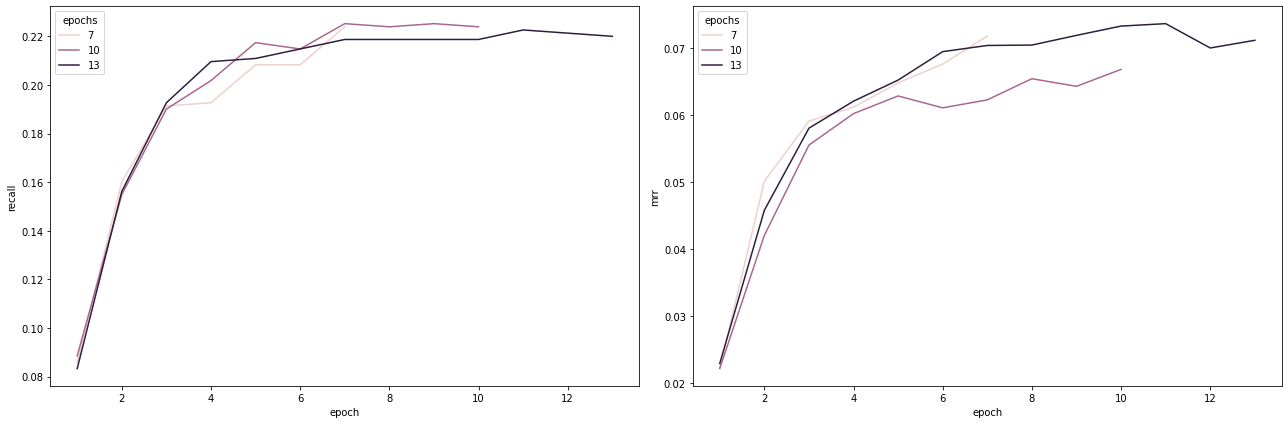

In [54]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.lineplot(x='epoch', y='recall', hue='epochs', data=epoch_result_df)

plt.subplot(122)
sns.lineplot(x='epoch', y='mrr', hue='epochs', data=epoch_result_df)

plt.tight_layout()

> epoch 10회 이후 Recall 값이 유의미하게 상승하진 않는다.
>
> mrr 값도 랜덤시드를 잡지 않고 실험하여 값에 차이가 발생하는 것 같다.
>
> loss값을 확인해보면 10회 이후 줄어들지 않는다. 오버피팅 시작되는듯..
>
> 재시도 하고 싶지만 시간을 너무 잡아먹으므로..

In [55]:
test_model(model, args, test)

Evaluation:  88%|████████▊ | 7/8 [00:03<00:00,  1.82it/s]


	 - Recall@20: 0.241071
	 - MRR@20: 0.099497



## 정리
* Session Based Recommendation 기능을 구현해봤다.
* 처음에 SessionID를 어떻게 잡을것이냐 삽질을 많이 했던 것 같다.
* 이후 하이퍼파라미터 튜닝도 꽤 시간을 잡아먹었다.
* 하이퍼파라미터 튜닝이후 `Recall` 0.24, `MRR` 0.09를 기록했다.
* 더 높은 수치를 기록해보고 싶었는데 아쉽다.